In [23]:
%load_ext autoreload
%autoreload 2


import os
import pymysql
import pandas as pd
from dotenv import load_dotenv, find_dotenv



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
env_path = find_dotenv()
load_dotenv(env_path)
#print(os.getenv('HOST'))
#print(os.getenv('USER_DB'))

True

In [25]:
# access to the data
conn = pymysql.connect(
    host=os.getenv('HOST'),
    port=int(3306),
    user=os.getenv('USER_DB'),
    passwd=os.getenv('PASSWORD_DB'),
    db=os.getenv('DB'),
    charset='utf8mb4')



## Easy features

-Resources added to queue

-Resources completed from queue

-Ratio of resources added to queue to completed

-Minutes learned per year



The first three is in the queue.py file. The last is in the time_learning.py

In [4]:
df_trk = pd.read_sql_query("SELECT * FROM tracking_event;", conn).drop_duplicates()
df_res = pd.read_sql_query("SELECT * FROM resource;", conn).drop_duplicates()

df_trk_copy=df_trk.copy()
df_res_copy=df_res.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [9]:
import numpy as np
# clean track_event

# reorder the dataframe according to the userID and eventDate
df_trk=df_trk_copy
df_trk.isna().sum()/len(df_trk) #content & skipMigration have over 80% missing values, delete these columns. And drop eventID
df_trk=df_trk.iloc[1:,:-2]
#df_trk['eventType'].apply(lambda)


# reorder 
df_trk=df_trk.sort_values(by=['userID','eventDate'],ascending=[True,True]).reset_index(drop=True)
df_trk
#-------------------------------------------------------------------------------------------

# return a dataframe with userID, eventType, source,eventDate, resourceType and action
# Get queueing status (returns 1 if completed from queue)
df_trk['resourceType']=df_trk['eventType'].apply(lambda x: x.split('_')[0])
df_trk['action']=df_trk['eventType'].apply(lambda x: x.split('_')[1])
df_trk.head(20)

# Get CompletionFromQueue (returns 1 if completed from the queue)


# Get mins learned per year(make this in a different py)



#Get resourceID and source
df_src=df_trk_copy[['resourceID','source']].drop_duplicates()
# create a dataframe with userID, numOfResourcesToQueue, numOfCompletionFromQueue, RatioOfCompletion_num, minOfResourcesToQueue, minOfCompletedFromQueue, RatioOfCompletion_min
# create "isQueued" columns, returns 1 if Queued
df_trk['isQueued']=df_trk['action'].map({'queued':1}).fillna(0).astype(int)
# create "isCompleted" columns, returns 1 if Completed
df_trk['isCompleted']=df_trk['action'].map({'completed':1, 'documented':1}).fillna(0).astype(int)

df_trk=df_trk.groupby(['userID','resourceID']).sum().reset_index()
# Get CompletionFromQueue (returns 1 if completed from the queue)
df_trk['CompletedFromQueue']=((df_trk['isQueued']==1)&(df_trk['isCompleted']==1)).astype(int)


df_trk=df_trk.merge(df_src,on='resourceID')


df_trk.head(20)

# add mins from the resourceID
df_res_select=df_res[['resourceID','min']].drop_duplicates()
df_trk=df_trk.merge(df_res_select,on='resourceID')
df_trk['minQueued']=df_trk['isQueued']*df_trk['min']
df_trk['minCompleted']=df_trk['CompletedFromQueue']*df_trk['min']


# if 'specified_source=True'
df_trk1=df_trk.groupby(['userID','source']).sum().reset_index()
df_trk1.rename(columns={'isQueued':'numQueued','CompletedFromQueue':'numCompletedFromQueue'},inplace=True)


df_trk1.head()

# if 'specified_source=False'
df_trk2=df_trk1.groupby(['userID']).sum().reset_index()
df_trk2['numQueued']=df_trk2['numQueued'].replace(0,-1)
df_trk2['minQueued']=df_trk2['minQueued'].replace(0,-1)
df_trk2['RatioOfCompletion_num']=np.abs(df_trk2['numCompletedFromQueue']/df_trk2['numQueued'])
df_trk2['RatioOfCompletion_min']=np.abs(df_trk2['minCompleted']/df_trk2['minQueued'])
# drop 'min' and 'isCompleted' as unnecessary
df_trk2=df_trk2.drop(['min','isCompleted'],axis=1)
#replace -1 back to 0
df_trk2['numQueued']=df_trk2['numQueued'].replace(-1,0)
df_trk2['minQueued']=df_trk2['minQueued'].replace(-1,0)
df_trk2.head(10)
#------------------------------------------------------------------

# if 'specified_source=True'
df_trk1['numQueued']=df_trk1['numQueued'].replace(0,-1)
df_trk1['minQueued']=df_trk1['minQueued'].replace(0,-1)
df_trk1['RatioOfCompletion_num']=np.abs(df_trk1['numCompletedFromQueue']/df_trk1['numQueued'])
df_trk1['RatioOfCompletion_min']=np.abs(df_trk1['minCompleted']/df_trk1['minQueued'])
#replace -1 back to 0
df_trk1['numQueued']=df_trk1['numQueued'].replace(-1,0)
df_trk1['minQueued']=df_trk1['minQueued'].replace(-1,0)
# drop min and 'isCompleted'
df_trk1=df_trk1.drop(['min','isCompleted'],axis=1)




In [10]:
df_trk1.head(20)

,userID,source,numQueued,numCompletedFromQueue,minQueued,minCompleted,RatioOfCompletion_num,RatioOfCompletion_min
0,00001d9c-5de5-4ed2-9ecc-98341286765a,ausmed,12,0,700.0,0.0,0.000000,0.000000
1,0000c854-c7a3-4047-9a54-2e1a3464621f,ausmed,0,0,0.0,0.0,0.000000,0.000000
2,000169ca-f6bf-4ac0-a13d-c2b188014962,ausmed,0,0,0.0,0.0,0.000000,0.000000
3,0001c897-b1fe-40e0-afef-6a667edf41f7,ausmed,0,0,0.0,0.0,0.000000,0.000000
4,0002e8b5-261b-44a6-b38c-2997b4007317,ausmed,0,0,0.0,0.0,0.000000,0.000000
5,0002f0ba-44b0-44d3-a542-3be3dd4d5036,ausmed,1,0,50.0,0.0,0.000000,0.000000
6,00034f05-a97f-4dfe-8162-f83b7709b392,ausmed,0,0,0.0,0.0,0.000000,0.000000
7,00036835-5926-476a-bd8a-65c39be4e6cc,ausmed,69,1,2009.0,7.0,0.014493,0.003484
8,0003f9de-385c-45dc-9b19-31df24266aa9,ausmed,0,0,0.0,0.0,0.000000,0.000000
9,00049633-8b5c-4a00-b869-4c107f941d13,ausmed,0,0,0.0,0.0,0.000000,0.000000


## Easy Feature Min per year

Two potential resources:

-'activity_20220808' (use this)

-tracking_event

-

Two Steps:
1.create a column to get user's Ausmed year (from user AusmedYear=lastest activity date-account createDate)
2.caculate the total min

In [5]:
# check activity data
nrow=200000
df_act=pd.read_sql_query(f"SELECT * FROM activity_20220808 LIMIT {nrow};", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()

df_act_copy=df_act.copy()
df_usr_copy=df_usr.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [12]:
import datetime as dt

# clean data here
# create a data frame with 'userID', 'activityType', 'providerName', 
df_act=df_act_copy
df_act['providerName'].unique()
#df_act['status'].unique()

# drop duplicated events
df_act=df_act.drop_duplicates(subset=['activityID','owner','resource','min'],keep='last')

# create minPerYear
## step1: get total min
selected_columns=['owner','providerName','min','updateDate','completeDate','activityType']
df_act=df_act[selected_columns]
#replace missing values of 'updateDate'
df_act['completeDate']=df_act['completeDate'].fillna(df_act['updateDate'])







df_act['providerName'].replace('N/A',None,inplace=True)
# see if can get missing values from tracking event!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!

# fill in missing value with 'Unknown'
df_act['providerName']=df_act['providerName'].fillna('Unknown')


#

# rename 'owner' as 'userID'
df_act.rename(columns={'owner':'userID'},inplace=True)
df_act.head(20)
##################################################################################

# get yearsOnAusmed 
df_usr=df_usr_copy[['userID','createDate']]
df_usr=df_usr.merge(df_act, on='userID', how='inner')
df_usr['yearsOnAusmed']=df_usr['completeDate']-df_usr['createDate']
df_usr=df_usr.groupby('userID').max().reset_index()
df_usr.head()

#####################################################################################
# get features here
# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType,minPerYear,percentageLearningFromAusmed
# create two columns to get favoriteActivityType, 2ndfavoriteActivityType
#define a function to get the nth/2nd most frequent activityType


def fav_activityType(series,n=2):
    ls=series.value_counts().index.tolist()[:n-1]
    return ls

# If a user has multiple favActivityType, randomly select one
def fav_fav(series):
    mode=series.mode()
    if len(mode)==1:
        return mode
    else:
        #print(mode)
        ind=random.randint(0,len(mode)-1)
        return mode[ind]



# create a column "isAusmed": returns 1 if the provider is Ausmend
df_act['isAusmed']=df_act['providerName'].apply(lambda x: 1 if ('Ausmed' in x) else 0 )
df_act['minOnAusmed']=df_act['min']*df_act['isAusmed']


# Get user's favorite and 2nd favorite activityType
# first create a copy of acticityType to get 2nd favorite activityType
df_act['2ndFavActivityType']=df_act['activityType']
df_act=df_act.groupby('userID').agg({'min': sum, 'minOnAusmed': sum, 'activityType': fav_fav, '2ndFavActivityType': fav_activityType}).reset_index()


# merge with df_usr
df_act1=df_act # save a copy
df_act=df_usr[['userID','yearsOnAusmed']].merge(df_act, on='userID', how='inner')


# rename the columns
df_act.rename(columns={'activityType': 'favActivityType'},inplace=True)





# get Min learnt from Ausmed
df_act['yearsOnAusmed']=df_act['yearsOnAusmed']/ np.timedelta64(1, 'Y')
df_act['minOnAusmedPerYear']=df_act['minOnAusmed']/df_act['yearsOnAusmed']

# get percentageOfLearningFromAusmed
df_act['minPerYear']=df_act['min']/df_act['yearsOnAusmed']
df_act['percentageOfLearningFromAusmed']=df_act['minOnAusmedPerYear']/df_act['minPerYear']

# drop uneeded columns
df_act=df_act.drop(columns=['yearsOnAusmed','min','minOnAusmedPerYear'])

# drop na
df_act=df_act.dropna()

# 


In [168]:
import numpy as np
import seaborn as sns
#df_act[df_act['providerName']=='N/A']

#df_act['favActivityType'].value_counts()
df_act['minPerYear'].plot.density()

NameError: name 'df_act' is not defined

# Hidden features

## Task1: % of users compliant per year (consdier hours of CPD completed and documented, learning goals set, context of practice set)

-CPD requirement is in the "groupRegulation"

-Goal: replacing intented 

-Q: how do we define overachiver/ casual learner/ ambitious learner

In [ ]:
# clean context of practice set

#create a table return CPD record with CPD hours required, CPD completed, documented

#create a goal table with column, goals per year, number of goals achived, ratio of goals achieved, ratio of 

# make compliency() function returns 

In [ ]:
# clean context of practice set
#load the data
df_cop = pd.read_sql_query("SELECT * FROM contextOfPractice;", conn)
df_pp=pd.read_sql_query("SELECT * FROM professionalprofile;", conn).drop_duplicates()
df_wk=pd.read_sql_query("SELECT * FROM work;", conn).drop_duplicates()
df_edu=pd.read_sql_query("SELECT * FROM education;", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()



df_cop_copy=df_cop.copy()
df_pp_copy=df_pp.copy()
df_wk_copy=df_wk.copy()
df_edu_copy=df_edu.copy()
df_usr_copy=df_usr.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versio

In [ ]:
# sneak peek 
import datetime as dt
df_cop=df_cop_copy
# df_cop=df_cop[['pProfile', 'typeOfPractice', 'located', 'specialities',
#        'population', 'focus', 'complex', 'autonomy', 'access', 'startDate',
#        'endDate', 'createDate', 'updateDate', 'topics', 'summary']]
#print(df_cop.columns)
#check
df_cop.isna().sum()/len(df_cop)# drop['topics', 'summary']
df_cop=df_cop[['pProfile', 'typeOfPractice', 'located', 'specialities',
       'population', 'focus', 'complex', 'autonomy', 'access', 'startDate',
       'endDate','createDate']]
# convert 'startDate','endDate'
#df_cop['startDate']=pd.to_datetime(df_cop['startDate'],errors='coerce')  

#df_cop[df_cop['startDate'].isna()]
df_cop.iloc[[3575,16699,29224,51510]]

# df_cop.iloc[[3575]]['startDate'] is '-2019-12-09' must have been typo, let's change that!
df_cop.at[3575,'startDate']='2019-12-09'
#df_cop.iloc[[3575]]
df_cop['startDate']=pd.to_datetime(df_cop['startDate'],errors='coerce')  
df_cop['createDate']=pd.to_datetime(df_cop['createDate'],errors='raise')  
df_cop[df_cop['startDate'].isna()]

# compute gap between createDate and startDate
#df_cop['gapBetweenStartAndCreate']=df_cop['createDate']-df_cop['startDate']
df_cop.head()
median=(df_cop['createDate']-df_cop['startDate']).median()
df_cop['startDate'].fillna(value=df_cop['createDate']-median,inplace=True)
df_cop['startDate']=df_cop['startDate'].apply(lambda x: dt.datetime(x.year,x.month,x.day))
#check previsously Nat rows
df_cop.iloc[[3575,16699,29224,51510]]

# get years of experience 
## replace missing values in endDate by current date
df_cop['endDate'].fillna(value=dt.date.today(),inplace=True)
df_cop['endDate']=pd.to_datetime(df_cop['endDate'],errors='coerce')
df_cop['yearsOfExperience']=df_cop['endDate']-df_cop['startDate']
#df_cop.info()

# link with userID
df_pp_select=df_pp[['pProfileID', 'owner','country']].drop_duplicates()
df_pp_select.head()
merged_df=df_cop.merge(df_pp_select,left_on='pProfile',right_on='pProfileID')\
.drop_duplicates().rename(columns={'owner':'userID'})# rename 'owner' as 'userID'

# drop 'pProfile' as redundant, move usersID and pProfileID to the front
merged_df=merged_df.drop(['pProfile','endDate','createDate'],axis=1)
cols = list(merged_df)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('pProfileID')))
cols.insert(0, cols.pop(cols.index('userID')))

merged_df = merged_df.loc[:, cols]
list(merged_df)

['userID',
 'pProfileID',
 'typeOfPractice',
 'located',
 'specialities',
 'population',
 'focus',
 'complex',
 'autonomy',
 'access',
 'country']

In [45]:
# main
# This table has one-to-many relationships, keep the lastest 
# return userID,typeOfPractice, located	specialities, population, focus, complex autonomy access startDate, yearsOfExperience
df_cop = pd.read_sql_query("SELECT * FROM contextOfPractice;", conn).drop_duplicates()
df_pp=df_pp_copy



# drop duplciates
df_cop = df_cop.drop_duplicates()

df_cop=df_cop[['pProfile', 'typeOfPractice', 'located', 'specialities',
       'population', 'focus', 'complex', 'autonomy', 'access','startDate','createDate','endDate']]

# df_cop.iloc[[3575]]['startDate'] is '-2019-12-09' must have been typo, let's change that!
df_cop.at[3575,'startDate']='2019-12-09'

# link with userID
df_pp_select=df_pp[['pProfileID', 'owner','country']].drop_duplicates()
df_pp_select.head()
merged_df=df_cop.merge(df_pp_select,left_on='pProfile',right_on='pProfileID')\
.drop_duplicates().rename(columns={'owner':'userID'})# rename 'owner' as 'userID'

# drop 'pProfile' as redundant, move usersID and pProfileID to the front
merged_df=merged_df.drop(['pProfile'],axis=1)
cols = list(merged_df)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('pProfileID')))
cols.insert(0, cols.pop(cols.index('userID')))


merged_df = merged_df.loc[:, cols].drop_duplicates().sort_values(by=['userID','startDate'],ascending=[True,False])

# only keep the lastest
merged_df.drop_duplicates(subset=['userID'],keep='first',ignore_index=True,inplace=True)
#merged_df.head(10)

# drop "startDate, createDate, endDate" as they are no longer needed
merged_df.drop(['startDate', 'createDate', 'endDate'],axis=1)
merged_df.head(10)


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,userID,pProfileID,typeOfPractice,located,specialities,population,focus,complex,autonomy,access,startDate,createDate,endDate,country
0,0000c854-c7a3-4047-9a54-2e1a3464621f,694b3b93-e762-427b-a1b8-72426d764a6c,private company,metropolitan centre,Perioperative Nursing,adults,clinical practice,generally complex,moderate,usually,2020-07-15,2020-07-14 21:46:21,None,AUS
1,00013cfc-f97f-428d-bf6b-558601512bd7,0bbfbfc8-5b48-4ca1-b05f-21638761d716,Other,metropolitan centre,"Immunisation,Cancer screening,General Practice",Other,nurse education,generally complex,moderate,usually,2017-06-01,2017-08-09 01:08:25,2018-05-31,AUS
2,00023498-c236-45f6-aaf1-ee382e520737,abcef1bf-aff5-45a8-b4e7-8c6a4a74a3d1,community,large rural centre,Paramedicine,adults,clinical practice,high complexity,moderate,usually,2018-12-01,2019-11-07 20:12:17,2019-11-30,AUS
3,0002f0ba-44b0-44d3-a542-3be3dd4d5036,5e540d39-66bc-422f-bd37-8b98ae0efd17,hospital,large rural centre,Surgical,adolescents or youth,clinical practice,generally complex,minimal,always,2022-02-01,2020-06-16 04:01:55,None,AUS
4,00049f68-a2a2-4d3d-bef6-f15c8c33a9dc,7885bef2-0959-4e88-878c-5eddb5850e1e,hospital,metropolitan centre,Intensive Care,adults,clinical practice,generally complex,moderate,always,2016-06-01,2017-02-27 20:46:37,2017-05-31,AUS
5,0008e1bc-589a-4bf3-ae16-ace555566578,ab2a1aed-322f-48b7-915d-7749ee02b65c,private practice,metropolitan centre,"Defence Nursing, GP nursing, small procedures,...",adults,clinical practice,very complex,high,always,2017-06-01,2017-06-04 12:46:32,2018-05-31,AUS
6,0009a8e2-e28f-47be-83fd-1f6d244d88c9,09f1c653-1127-43fa-a213-6b3515a8b21e,hospital,large rural centre,"Emergency,Critical Care",adults,clinical practice,very complex,moderate,always,2021-09-15,2021-05-14 04:21:07,None,AUS
7,000a1700-b302-415b-8c57-9ddcc1b61599,38bccb57-b74a-4cbf-9953-3879596b5e97,hospital,capital city,Clinical Nurse Specialist,Safety & Quality,management,be generally complex,moderate,always,2016-06-01,2016-10-17 23:16:22,2017-05-31,AUS
8,000a1b0d-5b7e-4ae1-a5a0-6fccab0c7559,e1c13c21-c769-4993-83b2-058373ce57d7,hospital,large rural centre,Orthopaedics,adults,clinical practice,generally complex,moderate,usually,2021-06-19,2021-06-18 22:28:44,None,AUS
9,000af191-1389-4cba-900e-e4a87debc02d,0da7e697-cef6-4493-a348-1160321ce2fe,hospital,capital city,Anaesthetic Nurse,children,clinical practice,generally complex,moderate,always,2018-04-23,2021-06-03 08:15:01,None,AUS


# Hidden Feature 

## Task 2: learning goals set

- learning goals set

- Goals set per year:

-- step 1: convert 'startDate' to year

-- step2: group userID then 'StartDate' in year

- Ratio of achived goals per year

- create a columns to isOverAchiever

- NLP on 'title', join all titles together (NLP during the final preprocessing)

In [4]:
# download relevent data
df_goal=pd.read_sql_query("SELECT * FROM goal;", conn).drop_duplicates()
df_gcs=pd.read_sql_query("SELECT * FROM goalCompetencyStandard;", conn).drop_duplicates()
df_grr=pd.read_sql_query("SELECT * FROM groupRegulation;", conn).drop_duplicates()
#rename owner to userID
df_goal.rename(columns={'owner': 'userID'},inplace=True)

df_goal_copy=df_goal.copy()
df_gcs_copy=df_gcs.copy()
df_grr_copy=df_grr.copy()


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [27]:
df_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122586 entries, 0 to 122585
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   goalID              122586 non-null  object        
 1   owner               122586 non-null  object        
 2   title               122586 non-null  object        
 3   startDate           122424 non-null  datetime64[ns]
 4   endDate             117569 non-null  datetime64[ns]
 5   startDateLocal      99468 non-null   object        
 6   endDateLocal        99468 non-null   object        
 7   topics              8216 non-null    object        
 8   priority            116228 non-null  float64       
 9   isAchieved          122586 non-null  int64         
 10  publicGoal          0 non-null       object        
 11  qualifications      8847 non-null    object        
 12  intendedMin         7911 non-null    float64       
 13  completedMin        122489 no

In [44]:
import datetime as dt
# get average goals per 
df_goal=df_goal_copy
df_goal['createDate']=pd.to_datetime(df_goal['createDate'])
df_goal['createYear']=pd.DatetimeIndex(df_goal['createDate']).year



df_goal=df_goal.groupby(['userID','createYear']).count().reset_index()

# get average goals per year
df_goal=df_goal[['userID','createYear','goalID']]
df_goal.rename(columns={'goalID': 'GoalsPerYear'},inplace=True)
df_goal=df_goal.groupby('userID').mean().reset_index()

# drop 'createYear'
df_goal.drop(columns=['createYear'],inplace=True )

df_goal

,userID,GoalsPerYear
0,00013cfc-f97f-428d-bf6b-558601512bd7,4.00
1,00023498-c236-45f6-aaf1-ee382e520737,6.00
2,0002f0ba-44b0-44d3-a542-3be3dd4d5036,2.75
3,00036835-5926-476a-bd8a-65c39be4e6cc,4.00
4,00049f68-a2a2-4d3d-bef6-f15c8c33a9dc,3.00
...,...,...
44763,fff95fa2-b077-4d86-9f53-e55976b01fa8,1.00
44764,fff97381-13d4-4622-ab51-67d69ccfde75,2.00
44765,fff9d181-6644-4112-b85e-30c649506f7a,1.00
44766,fffd42d4-0db4-467e-977d-7d826fdd7d8c,1.00


In [58]:
# Get ratio of compeleted goals
# retures a dataframe with all 'userID', 'ratioOfAchivedGoal'
df_goal=df_goal_copy


df_goal=df_goal.groupby('userID').agg({'goalID':'count', 'isAchieved': 'sum'}).reset_index()

df_goal['ratioOfAchivedGoals']=df_goal['isAchieved']/df_goal['goalID']
df_goal.rename(columns={'goalID': 'numOfGoals'},inplace=True)
# drop 'isAchieved' and 'numOfGoals' columns

df_goal.drop(columns=['numOfGoals','isAchieved'],inplace=True)

df_goal

,userID,ratioOfAchivedGoals
0,00013cfc-f97f-428d-bf6b-558601512bd7,0.000000
1,00023498-c236-45f6-aaf1-ee382e520737,0.000000
2,0002f0ba-44b0-44d3-a542-3be3dd4d5036,0.090909
3,00036835-5926-476a-bd8a-65c39be4e6cc,0.250000
4,00049f68-a2a2-4d3d-bef6-f15c8c33a9dc,0.000000


In [8]:
# get title
# join all goal titles together 
df_goal=df_goal_copy
df_goal['metaGoalTitle']=df_goal.groupby('userID')[['title']].transform(lambda x: ' '.join(x))
df_goal[['userID','metaGoalTitle']].drop_duplicates()

,userID,metaGoalTitle
0,e970fb89-6e51-4da5-a578-45c64e3c04fd,Everything
1,9629fc28-f907-4273-9a70-46777969bdb8,To settle into working for a new organisation ...
2,567120d7-eee6-4a3b-87f8-aaaa38f8b4e4,4 year old healthy kids check Managing paediat...
3,5ec5104d-513b-4cfb-9a7b-fd62bd74d2dd,Complete mandatory training\nImprove my triage...
4,0f88ad4e-35fe-4f2f-a237-f292dd805d16,"By the end of the CPD year, I will update and ..."
...,...,...
122560,ed39da52-b261-447d-8846-aa6899b61547,Maintaining currency with Paramedical practice...
122568,27c98ed3-fccf-482b-9523-6cd40eb40830,By the end of the CPD year I would like to hav...
122571,1ba2838e-cf34-4bc5-84a9-d4a01550fac6,I always want to practice with the most releva...
122572,8abc7348-9e10-4972-92b1-8c61b4b16cd3,I want to do at least 2 hrs of CPD per month b...


In [9]:
df_goal['userID'].nunique()# good

44768

<AxesSubplot:xlabel='createDate', ylabel='Count'>

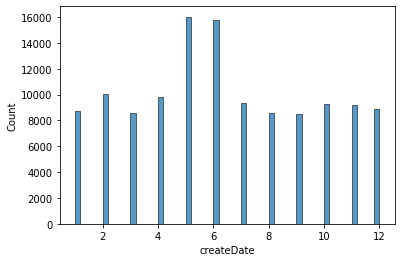

In [34]:
# see which month over the years has the most goals set
import seaborn as sns
df_goal=df_goal_copy
df_goal['createDate']=pd.to_datetime(df_goal['createDate'])
sns.histplot(pd.DatetimeIndex(df_goal['createDate']).month)

# Baseline Model

Let's pipe line up!

Preprocessing: 
- basic scaling all numerical features

- do not use favActivityType, come back later!


- MiniBatichKmeans: play around with the number of clusters

In [1]:
from customerclustering.db_connection import Db
from customerclustering.get_training_data import *

In [26]:
import time
start_time = time.time()
# access to the data
conn = pymysql.connect(
    host=os.getenv('HOST'),
    port=int(3306),
    user=os.getenv('USER_DB'),
    passwd=os.getenv('PASSWORD_DB'),
    db=os.getenv('DB'),
    charset='utf8mb4')




rows=200000
df=GetTrainingData(conn,rows).get_training_data()
df_copy=df.copy()
print("--- %s seconds ---" % (time.time() - start_time))
df.head()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versio

--- 265.63653588294983 seconds ---


,Product,Status,userID,stripeCustID,num_subs,account_age,pProfileID,typeOfPractice,located,specialities,...,RatioOfCompletion_num,RatioOfCompletion_min,event_cpd_day_diff,doc_in_activation,activated,plan_type,subscribe_days,GoalsPerYear,ratioOfAchivedGoals,metaGoalTitle
0,Ausmed Subscription,incomplete_expired,6037d38d-d098-4f68-be8c-49b7131b8116,cus_CVloz8uJiXpqfF,10,1613.0,41b3e81d-ccdd-40c8-b268-874344b0a1bf,hospital,remote area,"Rehabilitation,Aged care ,Medical",...,0.000000,0.000000,117.197044,10,1,quarterly,1538,5.0,0.4,"To gain confidence ,skills and knowledge as a ..."
1,Ausmed Subscription,canceled,62d1fe96-34f6-4992-9f15-b240f07770d8,cus_EoCO9ITZcMHmkA,9,1233.0,71a06b47-4762-49d2-b5fd-161c7ce6e1cd,hospital,large rural centre,Addiction and Substance Abuse,...,0.000000,0.000000,164.064103,2,1,quarterly,0,1.5,0.0,Do my best Gehenna d f r dwa wa daw daw
2,Ausmed Subscription,canceled,6e6b0e01-4a29-4724-a781-5d6a0d72a213,cus_BVqWWYIZ4tLhQr,6,2122.0,0cccdf89-bae9-4d06-8a40-81a6c7b3b7ce,GP Surgery,metropolitan centre,"Immunisation,Chronic Illness",...,0.111111,0.071138,149.362205,4,1,monthly,193,2.0,0.0,Covid vaccination and wound management. \nMy r...
3,Ausmed Subscription,active,33d2881f-8bc6-4b98-bafe-bfd20b141ee2,cus_AVUDPqhuPS9HRy,5,1945.0,72593341-edad-404e-9a92-bf7f576e5207,hospital,metropolitan centre,aged care; wound care and the continuity of he...,...,0.043478,0.013096,76.311787,2,1,quarterly,315,1.0,0.0,By the end of 2021 I would like to expand my k...
4,Ausmed Subscription,incomplete_expired,5f048ee3-4ea0-41e1-b859-c1cd9c95d80b,cus_F71ikWaGTyumEe,5,1183.0,752db353-5793-4636-acd7-fe3205291c91,Unemployed.,small rural centre,N/A,...,0.000000,0.000000,8.618321,4,1,quarterly,73,2.0,0.0,"Study, learn and retain knowledge. Do online s..."


In [27]:
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')

# reindex df
df=df_copy
#df=df.set_index('userID')

# drop 'pProfileID' and 'stripeCustID' and Date columns
df.drop(columns=['pProfileID','stripeCustID','startDate', 'endDate', 'createDate'],inplace=True)

# select columns
# use all numerical columns
num_col=df.describe().columns
#do not include meta_title
cat_col=[col for col in df.columns if (col not in num_col)&(col!='metaGoalTitle')]
print(cat_col)

# Robustscaler all numerical columns
num_transformer=RobustScaler()

#LabelEncoder all categorical columns
cat_transformer=LabelEncoder()


# Our first base pipeline-doesn;t work
preproc=make_column_transformer((num_transformer,num_col),(cat_transformer,cat_col))



# manually transform the numerical and categorical columns
## numerical
df_num=pd.DataFrame(num_transformer.fit_transform(df[num_col]))
df_num.columns=num_col
df_num.head()

## categorical
df_cat=df[cat_col].apply(cat_transformer.fit_transform)

df_processed=df_num
df_processed[cat_col]=df_cat
df_processed.head()

# reindex df by userID
df_processed.set_index(df['userID'],inplace=True)
df_processed

#basepipe=make_pipeline(preproc,MiniBatchKMeans()) #shame on you!

#basepipe

['Product', 'Status', 'userID', 'typeOfPractice', 'located', 'specialities', 'population', 'focus', 'complex', 'autonomy', 'access', 'country', 'favActivityType', '2ndFavActivityType', 'plan_type']


,num_subs,account_age,minPerYear,percentageOfLearningFromAusmed,numQueued,numCompletedFromQueue,minQueued,minCompleted,RatioOfCompletion_num,RatioOfCompletion_min,...,specialities,population,focus,complex,autonomy,access,country,favActivityType,2ndFavActivityType,plan_type
userID,,,,,,,,,,,,,,,,,,,,,
6037d38d-d098-4f68-be8c-49b7131b8116,9.0,0.032370,2.233089,-0.138041,-0.142857,0.0,-0.042,0.0,0.000000,0.000000,...,2635,375,376,2,2,0,1,11,11,2
62d1fe96-34f6-4992-9f15-b240f07770d8,8.0,-0.406936,2.476042,0.660661,-0.333333,0.0,-0.256,0.0,0.000000,0.000000,...,98,374,400,2,0,2,1,11,12,2
6e6b0e01-4a29-4724-a781-5d6a0d72a213,5.0,0.620809,-0.156912,-0.112924,-0.095238,1.0,0.008,35.0,0.111111,0.071138,...,1477,375,387,2,2,0,1,10,11,1
33d2881f-8bc6-4b98-bafe-bfd20b141ee2,4.0,0.416185,-0.363395,0.660661,1.666667,2.0,1.425,25.0,0.043478,0.013096,...,3163,375,371,2,2,0,1,11,12,2
5f048ee3-4ea0-41e1-b859-c1cd9c95d80b,4.0,-0.464740,0.019131,0.660661,0.523810,0.0,0.772,0.0,0.000000,0.000000,...,1935,266,194,5,1,1,1,11,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffde3d2e-1f3e-4dfa-a166-22d1c7950b4c,0.0,-0.514451,-0.354996,0.660661,0.238095,0.0,0.293,0.0,0.000000,0.000000,...,2701,375,376,5,0,2,1,10,12,2
ffded699-79d7-4e0d-82d9-c30117a0ad1b,0.0,0.356069,-0.080773,-0.339339,-0.285714,0.0,-0.224,0.0,0.000000,0.000000,...,3118,415,376,2,2,0,1,11,2,2
ffef04f1-35a5-4af4-95ed-8ac18a6b1ceb,0.0,0.335260,1.393386,0.660661,0.000000,0.0,0.197,0.0,0.000000,0.000000,...,2762,375,376,2,2,0,1,5,5,1


### Use Elbow Method to find the optimal cluster size

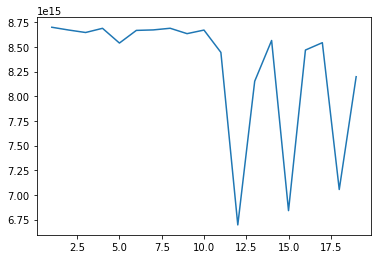

In [28]:
import matplotlib.pyplot as plt
# find the optimal n_cluster
X=df_processed
# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(X).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss)

Looks like the optimal number of cluster is around 14, but should we go that far? Maybe 8 is enough?

# Visualization of the Basemodel Output

In [30]:
# The baseline model
print(f"The optimal cluster size is {clusters[wcss.index(min(wcss))]}") # this gives 14
n_cluster=14
base_model=MiniBatchKMeans(n_clusters=12)
X_pred=base_model.fit(df_processed).predict(df_processed)


The optimal cluster size is 12


In [32]:
# get centers
df_centers=pd.DataFrame(base_model.cluster_centers_)
df_centers.columns=df_processed.columns
df_des=df_centers.describe()
df_des

,num_subs,account_age,minPerYear,percentageOfLearningFromAusmed,numQueued,numCompletedFromQueue,minQueued,minCompleted,RatioOfCompletion_num,RatioOfCompletion_min,...,specialities,population,focus,complex,autonomy,access,country,favActivityType,2ndFavActivityType,plan_type
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.097458,-0.159830,29156.445251,0.136434,0.308951,0.357701,0.340017,7.967779,0.022592,0.012978,...,1804.392032,379.744971,368.871893,3.254721,1.374098,1.186029,1.001103,8.754392,8.769005,1.634921
std,0.064442,0.101180,100614.612508,0.086837,0.145142,0.148628,0.158265,2.805289,0.007401,0.004685,...,929.461767,9.282117,3.436722,0.423423,0.162027,0.321273,0.001858,0.891350,1.204667,0.154820
min,0.035514,-0.407433,-11.515475,0.001767,0.115239,0.114953,0.126216,3.348598,0.006730,0.004147,...,345.850838,365.047986,364.180095,2.582243,1.052428,0.793185,0.999621,6.116822,5.624406,1.272727
25%,0.066904,-0.182561,4.741810,0.082416,0.209232,0.298864,0.250772,7.057306,0.019693,0.010062,...,1118.732395,372.765436,367.547560,2.934143,1.290218,0.945618,1.000000,8.826922,8.551186,1.648534
50%,0.085949,-0.155504,14.194683,0.116584,0.295779,0.318759,0.299970,7.753914,0.021232,0.013012,...,1767.328401,378.321837,368.337865,3.269290,1.413766,1.145127,1.000000,9.071548,9.080645,1.677991
75%,0.099565,-0.122131,80.069316,0.211995,0.385413,0.365217,0.391589,8.439473,0.026479,0.014253,...,2677.294973,388.186016,370.190805,3.545466,1.485843,1.356574,1.001981,9.172193,9.328243,1.705945
max,0.287430,-0.005121,348649.557110,0.270246,0.579994,0.704012,0.675622,13.730129,0.034186,0.022693,...,2986.857009,395.786849,377.456418,3.933057,1.559813,1.885047,1.006071,9.407290,10.272897,1.798131


In [36]:
df_des.loc['std',:].sort_values(ascending=False)

minPerYear                        100614.612508
userID                              1788.648522
specialities                         929.461767
population                             9.282117
typeOfPractice                         6.278664
focus                                  3.436722
minCompleted                           2.805289
2ndFavActivityType                     1.204667
favActivityType                        0.891350
complex                                0.423423
located                                0.364256
access                                 0.321273
GoalsPerYear                           0.265484
doc_in_activation                      0.189967
subscribe_days                         0.171761
autonomy                               0.162027
minQueued                              0.158265
plan_type                              0.154820
numCompletedFromQueue                  0.148628
numQueued                              0.145142
Status                                 0

Text(0.5, 0.92, 'simple 3D scatter plot')

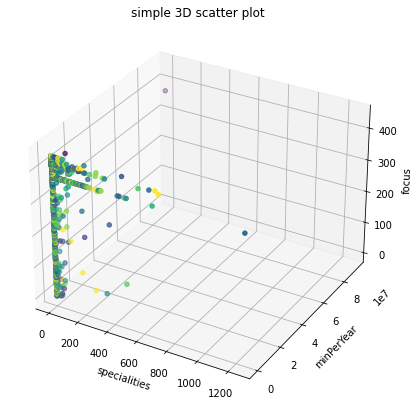

In [45]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# Choose the columns have large std from the describe table
x=df_processed.minPerYear 
y=df_processed.minCompleted
z=df_processed.population

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, c = X_pred)
ax.set_xlabel('specialities')
ax.set_ylabel('minPerYear')
ax.set_zlabel('focus')
plt.title("simple 3D scatter plot")

In [ ]:
df_processed

In [6]:
import numpy as np
df_act=df_act_copy
# clean data here
# create a data frame with 'userID', 'activityType', 'providerName', 
df_act=df_act_copy
df_act['providerName'].unique()
#df_act['status'].unique()

# drop duplicated events
df_act=df_act.drop_duplicates(subset=['activityID','owner','resource','min'],keep='last')

# create minPerYear
## step1: get total min
selected_columns=['owner','providerName','min','updateDate','completeDate','activityType']
df_act=df_act[selected_columns]
#replace missing values of 'updateDate'
df_act['completeDate']=df_act['completeDate'].fillna(df_act['updateDate'])







df_act['providerName'].replace('N/A',None,inplace=True)
# see if can get missing values from tracking event!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!

# fill in missing value with 'Unknown'
df_act['providerName']=df_act['providerName'].fillna('Unknown')


#

# rename 'owner' as 'userID'
df_act.rename(columns={'owner':'userID'},inplace=True)
df_act.head(20)
##################################################################################

# get yearsOnAusmed 
df_usr=df_usr_copy[['userID','createDate']]
df_usr=df_usr.merge(df_act, on='userID', how='inner')
df_usr['yearsOnAusmed']=df_usr['completeDate']-df_usr['createDate']
df_usr=df_usr.groupby('userID').max().reset_index()
df_usr.head()

#####################################################################################
# get features here
# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType,minPerYear,percentageLearningFromAusmed
# create two columns to get favoriteActivityType, 2ndfavoriteActivityType
#define a function to get the nth/2nd most frequent activityType
import random #yep Ran so random

def fav_activityType(series,n=2):
    ls=series.value_counts().index.tolist()[:n-1]
    return ls

# to handle multiple mode
def fav_fav(series): 
    mode=series.mode()
    if len(mode)==1:
        return mode
    else: 
        #print(mode)
        ind=random.randint(0,len(mode)-1)
        return mode[ind]
        #return random.shuffle(mode)[0]


# create a column "isAusmed": returns 1 if the provider is Ausmend
df_act['isAusmed']=df_act['providerName'].apply(lambda x: 1 if ('Ausmed' in x) else 0 )
df_act['minOnAusmed']=df_act['min']*df_act['isAusmed']


# Get user's favorite and 2nd favorite activityType
# first create a copy of acticityType to get 2nd favorite activityType
df_act['2ndFavActivityType']=df_act['activityType']
df_act=df_act.groupby('userID').agg({'min': sum, 'minOnAusmed': sum, 'activityType': fav_fav, '2ndFavActivityType': fav_activityType}).reset_index()
#mode=df_act['activityType'].mode()
#fav_fav(df_act['activityType'])

NameError: name 'df_act_copy' is not defined

In [34]:
len(mode)

1

array(['e-Learning'], dtype=object)

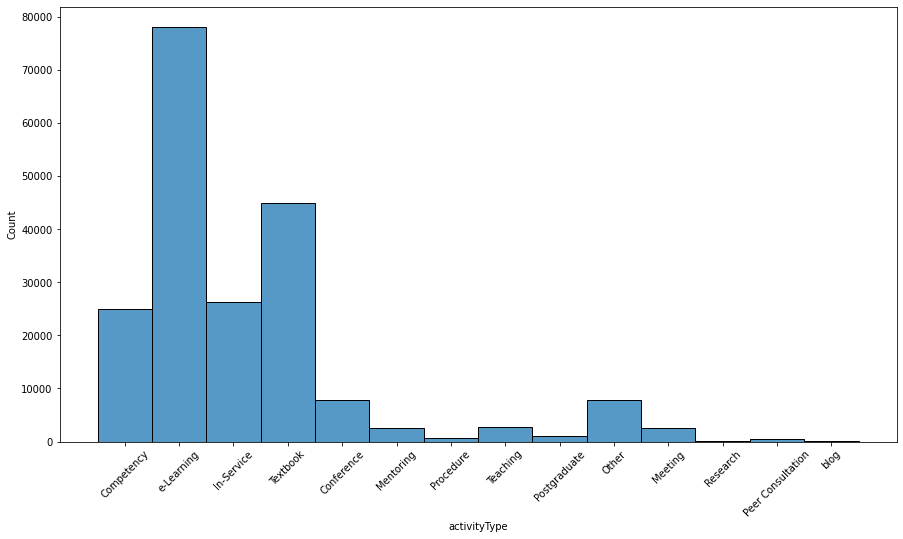

In [22]:
# exploring the distribution of activityType
import matplotlib.pyplot as plt
import seaborn as sns
df_act=df_act_copy
plt.figure(figsize = (15,8))
ax =sns.histplot(df_act['activityType'])
plt.xticks(rotation=45)



In [ ]:
#